In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# EDA

In [2]:
# Load the dataset
df = pd.read_csv("../data/pair_data.csv")
df.shape

(318, 9)

In [3]:
df.head()

,prompt,hq1,hq2,mq1,lq1,lq2,lq3,lq4,lq5
0,"I know I am too big, and I probably should exe...",You are starting to think it’s time to do some...,You have put a lot of effort into losing weigh...,You don't know how you'd fit exercise into you...,It's free to exercise at home. Maybe ride your...,"Do you have a cheap gym near you, like a Plane...","You always have time for something, and about ...","Your feelings are valid, but I would advise th...","Start with small steps, start exercising at ho..."
1,I don’t trust doctors. I don’t trust the CDC....,You feel that your immune systems is strong en...,Putting your trust in others is hard for you. ...,You believe God will protect you from COVID-19.,"Well, we don’t know who is naturally able to a...",Do you think everyone in healthcare is in it f...,"Otherwise, the fight against COVID is hard, so...","Well, taking covid vaccine can help you in dev...",How does your opinion affect the people around...
2,"Doctor x, I don’t want the Covid vaccine for m...",You are worried about long term effects from t...,You're concerned that not enough research has ...,You want more information before choosing to v...,Let me tell you about what we know about how s...,Don't you know the long-term side effects of g...,"If indicated, trust that it is safe.",I can absolutely respect that decision. Is the...,The Covid vaccine is very safe and only very f...
3,I know I should probably get the vaccine. I ha...,While you have some concerns about the vaccine...,"You want to protect your mom, but you're worri...",You don't want to give your mom COVID.,You need to protect your mother and get over y...,Do you believe the side effects of the vaccine...,"Follow what experts say, not what you hear fro...",I know it can sound intimidating but consider ...,Stop listening to bad advice and get the facts...
4,I know because I am so heavy and have diabetes...,Although part of you knows exercise might help...,because of your crazy schedule with the kids a...,You don't see a way to make exercise fit in yo...,"Well, you can exercise at home. Maybe ride you...",Can you play basketball with your husband?,Concile your husband to help you with your hom...,"The good news is that diet, not exercise, is t...",Have you tried looking for ways to incorporate...


In [4]:
# Look at a prompt
pprint(df['prompt'][5])

('Of course, I would like to lose weight and not feel gross all the time. But '
 'I hate all the diets my mom puts me on. I’ve tried them all. Every time I '
 'end up feeling deprived and hungry. Then I gain all the weight back. I’m '
 'getting ready to give up.')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  318 non-null    object
 1   hq1     318 non-null    object
 2   hq2     318 non-null    object
 3   mq1     318 non-null    object
 4   lq1     318 non-null    object
 5   lq2     318 non-null    object
 6   lq3     318 non-null    object
 7   lq4     318 non-null    object
 8   lq5     318 non-null    object
dtypes: object(9)
memory usage: 22.5+ KB


In [6]:
# Check for duplicate rows
print(df.duplicated().sum())

0


In [7]:
# How many unique prompts do we have?
print(f'There are {df.prompt.nunique()} unique questions in the dataset.')

There are 318 unique questions in the dataset.


In [8]:
# Count null values in each column
null_counts = df.isnull().sum()
print(null_counts)

prompt    0
hq1       0
hq2       0
mq1       0
lq1       0
lq2       0
lq3       0
lq4       0
lq5       0
dtype: int64


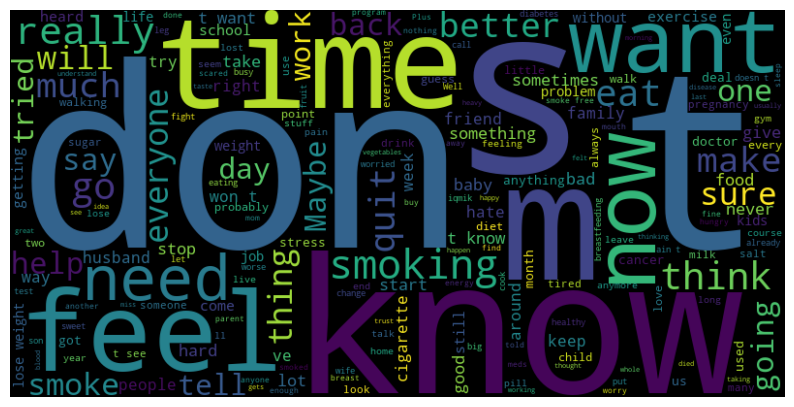

In [9]:
# Plot wordcloud with raw prompt data
text = ' '.join(df['prompt'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

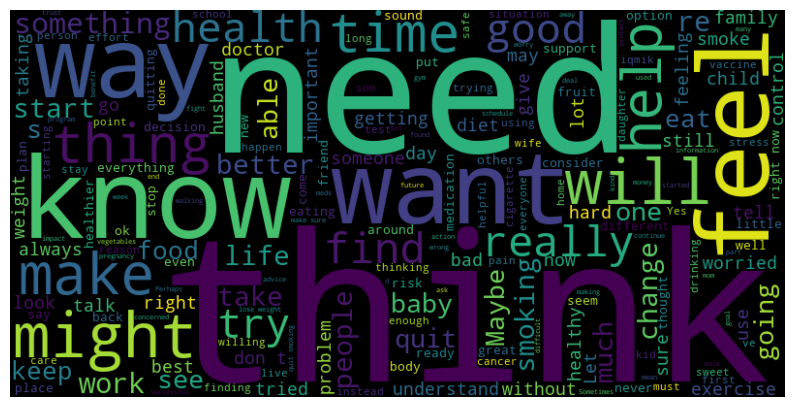

In [10]:
# Plot wordcloud with response
columns_to_combine = ['hq1', 'hq2', 'mq1', 'lq1', 'lq2', 'lq3', 'lq4', 'lq5']
text = ' '.join(df[columns_to_combine].astype(str).stack())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data Cleaning

There's minimal data cleaning to do here because there are no nulls or duplicates. We just need to properly format the text.

In [11]:
def clean_and_lowercase_text(text):
    """
    Cleans text by removing or replacing irrelevant characters (e.g. special symbols, HTML tags) and lowercases it.
    """
    # Ensure text is a string
    text = str(text)
    
    # Replace newline and tab characters with a space
    text = re.sub(r'[\n\t\r]', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove special characters except for essential punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.lower()

In [12]:
# Apply function and clean text
for c in df.columns:
    df[c] = df[c].apply(clean_and_lowercase_text)

In [13]:
df.head()

,prompt,hq1,hq2,mq1,lq1,lq2,lq3,lq4,lq5
0,"i know i am too big, and i probably should exe...",you are starting to think its time to do somet...,you have put a lot of effort into losing weigh...,you don't know how you'd fit exercise into you...,it's free to exercise at home. maybe ride your...,"do you have a cheap gym near you, like a plane...","you always have time for something, and about ...","your feelings are valid, but i would advise th...","start with small steps, start exercising at ho..."
1,i dont trust doctors. i dont trust the cdc. go...,you feel that your immune systems is strong en...,putting your trust in others is hard for you. ...,you believe god will protect you from covid-19.,"well, we dont know who is naturally able to av...",do you think everyone in healthcare is in it f...,"otherwise, the fight against covid is hard, so...","well, taking covid vaccine can help you in dev...",how does your opinion affect the people around...
2,"doctor x, i dont want the covid vaccine for me...",you are worried about long term effects from t...,you're concerned that not enough research has ...,you want more information before choosing to v...,let me tell you about what we know about how s...,don't you know the long-term side effects of g...,"if indicated, trust that it is safe.",i can absolutely respect that decision. is the...,the covid vaccine is very safe and only very f...
3,i know i should probably get the vaccine. i ha...,while you have some concerns about the vaccine...,"you want to protect your mom, but you're worri...",you don't want to give your mom covid.,you need to protect your mother and get over y...,do you believe the side effects of the vaccine...,"follow what experts say, not what you hear fro...",i know it can sound intimidating but consider ...,stop listening to bad advice and get the facts...
4,i know because i am so heavy and have diabetes...,although part of you knows exercise might help...,because of your crazy schedule with the kids a...,you don't see a way to make exercise fit in yo...,"well, you can exercise at home. maybe ride you...",can you play basketball with your husband?,concile your husband to help you with your hom...,"the good news is that diet, not exercise, is t...",have you tried looking for ways to incorporate...


## Preprocess the data

In [14]:
# Pivot df to get prompt-response-rating groups
df_melted = df.melt(id_vars=["prompt"], var_name="rating", value_name="response")
df_melted.shape

(2544, 3)

In [15]:
df_melted.head()

,prompt,rating,response
0,"i know i am too big, and i probably should exe...",hq1,you are starting to think its time to do somet...
1,i dont trust doctors. i dont trust the cdc. go...,hq1,you feel that your immune systems is strong en...
2,"doctor x, i dont want the covid vaccine for me...",hq1,you are worried about long term effects from t...
3,i know i should probably get the vaccine. i ha...,hq1,while you have some concerns about the vaccine...
4,i know because i am so heavy and have diabetes...,hq1,although part of you knows exercise might help...


In [16]:
# Combine prompt and response for feature extraction
df_melted['combined_text'] = df_melted['prompt'] + " " + df_melted['response']
df_melted['combined_text']

0       i know i am too big, and i probably should exe...
1       i dont trust doctors. i dont trust the cdc. go...
2       doctor x, i dont want the covid vaccine for me...
3       i know i should probably get the vaccine. i ha...
4       i know because i am so heavy and have diabetes...
                              ...                        
2539    i dont eat any lunchmeat anymore, bread hardly...
2540    well, i read canned vegetables are better than...
2541    i can do that when im at the store. who decide...
2542    id like to eat less processed foods, but i gue...
2543    i like going to the gym, i like exercising i e...
Name: combined_text, Length: 2544, dtype: object

In [17]:
# Map the rating to the level
df_melted['rating_level'] = df_melted['rating'].map(
    {
        'hq1': 'high',
        'hq2': 'high',
        'mq1': 'medium',
        'lq1': 'low',
        'lq2': 'low',
        'lq3': 'low',
        'lq4': 'low',
        'lq5': 'low',
    }
)

# Feature Engineering

In [18]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 terms for efficiency
    stop_words='english',  # Remove common English stop words
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform the combined text column
tfidf_features = tfidf_vectorizer.fit_transform(df_melted['combined_text'])
X = tfidf_features.toarray()

# Save the vectorizer
joblib.dump(tfidf_vectorizer, "../models/vectorizer.pkl")

# Convert to DataFrame for easier inspection (optional)
tfidf_df = pd.DataFrame(X, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,10,15,15 minutes,15 pounds,16,1994,45,46,50,50 im,...,youre concerned,youre starting,youre worried,youve,yummy,yummy stuff,zombie,zombie aint,zone,zone diet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'rating' column
df_melted['rating_label'] = label_encoder.fit_transform(df_melted['rating_level'])

# Print mapping of topics to numeric labels
pprint(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Save the labels for modeling
y = df_melted['rating_label']

# Save the trained label encoder
joblib.dump(label_encoder, "../models/label_encoder.pkl")

{'high': 0, 'low': 1, 'medium': 2}


['../models/label_encoder.pkl']

In [20]:
# Look at balance of classes
y.value_counts()

rating_label
1    1590
0     636
2     318
Name: count, dtype: int64

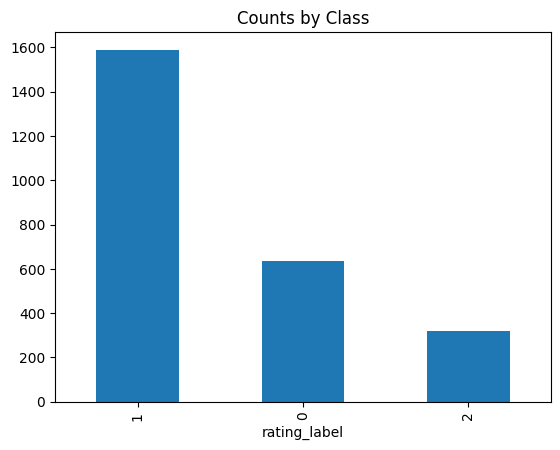

In [21]:
y.value_counts().plot(kind='bar')
plt.title('Counts by Class');

# Models

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Multiple Regression

Start with simplest model, multiple regression, because regression models are interpretable and can give you insights into which features (e.g., specific terms in the text) are most predictive of response ratings. Also a good baseline.

In [23]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4.410872955994867e+25


## Logistic Regression

We can use logistic regression if we treat this as a classification problem, predicting the class (rating level - low, medium, high). This is also a simple and interpretable model choice.

In [24]:
# Train model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.47      0.48       133
           1       0.66      0.47      0.55       315
           2       0.01      0.02      0.01        61

    accuracy                           0.42       509
   macro avg       0.38      0.32      0.35       509
weighted avg       0.53      0.42      0.47       509



## Random Forest

A non-linear model that handles class imbalance well (via class_weight parameter). Captures complex interactions between features without heavy tuning.

In [25]:
# Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49       133
           1       0.67      0.89      0.76       315
           2       0.05      0.02      0.03        61

    accuracy                           0.65       509
   macro avg       0.47      0.43      0.43       509
weighted avg       0.60      0.65      0.60       509



## Gradient Boosting Model - XGBoost

Powerful for structured data and often outperform simpler models. Great for handling imbalanced datasets and structured data.
High performance with minimal feature engineering.

In [26]:
# Calculate sample weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Assign sample weights
sample_weights = np.array([class_weights[label] for label in y_train])

# Train model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57       133
           1       0.73      0.71      0.72       315
           2       0.14      0.21      0.17        61

    accuracy                           0.60       509
   macro avg       0.50      0.48      0.48       509
weighted avg       0.63      0.60      0.61       509



In [27]:
# Save the trained XGBoost model
joblib.dump(model, "../models/xgboost_model.pkl")

['../models/xgboost_model.pkl']

## Results

- Multiple regression performs terribly which could be because text data isn't well-represented for regression purposes without proper feature engineering
- Logistic regression performs better than linear regression but struggles significantly with the minority class (Class 2). The imbalance in class distribution is hurting the model's ability to predict Class 2.
- The RandomForestClassifier significantly improves overall accuracy and performance for the majority class (Class 1) but it still struggles with Class 2, due to its rarity in the dataset.
- XGBoost performed the best in terms of accuracy and F1 scores overall. All models struggles with class 2, which makes sense since it was underrepresented.

## Next Steps

- Hyperparameter tuning (use GridSearchCV or RandomizedSearchCV to optimize)
- Try more advanced models like transformer-based models (e.g. BERT) or neural networks

## Test on Novel Data

In [28]:
def preprocess_new_data(new_prompts, new_responses, vectorizer):
    """
    Preprocess new data for the model.
    Combine prompts and responses, then transform using the vectorizer.
    """
    # Combine prompts and responses
    combined_text = [f"{prompt} {response}" for prompt, response in zip(new_prompts, new_responses)]
    
    # Vectorize using the trained vectorizer
    transformed_features = vectorizer.transform(combined_text)
    return transformed_features

In [29]:
def make_predictions(model, preprocessed_features, label_encoder):
    """
    Use the trained XGBoost model to make predictions.
    Decodes labels to their original format (if encoded).
    """
    # Predict using the trained model
    predictions = model.predict(preprocessed_features)
    
    # If label encoder was used, decode the predictions
    decoded_predictions = label_encoder.inverse_transform(predictions)
    return decoded_predictions

In [30]:
# Sample new data
new_prompts = [
    "The client is experiencing anxiety after a major life transition.",
    "The client reports difficulty focusing at work.",
]
new_responses = [
    "Recommend mindfulness exercises and gradual exposure therapy.",
    "Suggest trying time management strategies and workplace accommodations."
]

# Preprocess new data
new_features = preprocess_new_data(new_prompts, new_responses, tfidf_vectorizer)

# Make predictions
predicted_ratings = make_predictions(model, new_features, label_encoder)

# Display results
for i, (prompt, response, rating) in enumerate(zip(new_prompts, new_responses, predicted_ratings)):
    print(f"Example {i + 1}")
    print(f"Prompt: {prompt}")
    print(f"Response: {response}")
    print(f"Predicted Rating: {rating}")
    print("-" * 40)

Example 1
Prompt: The client is experiencing anxiety after a major life transition.
Response: Recommend mindfulness exercises and gradual exposure therapy.
Predicted Rating: high
----------------------------------------
Example 2
Prompt: The client reports difficulty focusing at work.
Response: Suggest trying time management strategies and workplace accommodations.
Predicted Rating: high
----------------------------------------
